In [2]:
from utils.thresholding import *
from pynq import Overlay
from pynq import MMIO
import matplotlib.pyplot as plt
import time
import threading
import cv2
import queue

In [ ]:
def compute_lane_heading_angle(left_fit=None, right_fit=None, y_eval=200):
    angles = []

    def angle_from_fit(fit):
        # Derivative of the 2nd-order polynomial at y = y_eval
        dy = 1.0  # pixel change in y
        dx = 2 * fit[0] * y_eval + fit[1]  # derivative at y_eval
        angle_rad = np.arctan(dx)  # slope to angle
        return -np.degrees(angle_rad)

    if left_fit is not None:
        angles.append(angle_from_fit(left_fit))
    if right_fit is not None:
        angles.append(angle_from_fit(right_fit))

    if angles:
        print(angles)
        # Average heading angle from both lanes
        return np.mean(angles)
    else:
        return None


In [ ]:
def detect_lane_lines_connected_components(binary_warped):
    # Ensure the input is binary (0 and 255)
    binary = np.uint8(binary_warped * 255) if binary_warped.max() <= 1 else np.uint8(binary_warped)

    # Apply connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    # Image dimensions
    height, width = binary.shape

    # Store points
    leftx, lefty, rightx, righty = [], [], [], []

    for i in range(1, num_labels):  # Label 0 is background
        x, y, w, h, area = stats[i]
        cx, cy = centroids[i]

        # Heuristic filters for likely lane lines
        if area > 1000 and h > 30:
            if cx < width // 2:
                coords = np.column_stack(np.where(labels == i))
                for pt in coords:
                    lefty.append(pt[0])
                    leftx.append(pt[1])
            else:
                coords = np.column_stack(np.where(labels == i))
                for pt in coords:
                    righty.append(pt[0])
                    rightx.append(pt[1])

    # Convert lists to numpy arrays
    leftx = np.array(leftx)
    lefty = np.array(lefty)
    rightx = np.array(rightx)
    righty = np.array(righty)

    return leftx, lefty, rightx, righty

In [ ]:
# Change this to match desired camera resolution
#frame_in_w = 640
#frame_in_h = 480

#curvature = 1000

# Change these variables based on our car.
#wheelbase = 2.6 # Length of car from front to back in meters (originally 0.1524)
#n = 16 # Steering factor (originally 16)

#wheelbase = 0.1524 # Length of car from front to back in meters (originally 0.1524)
#n = 1 # Steering factor (originally 16)

################################################
WIDTH = 640
HEIGHT = 480

frame_in_w = 640
frame_in_h = 480

ym_per_pix = 0.1524 / 72.0
xm_per_pix = 0.2286 / 600.0
y_eval = 210
midx = 320

y_bottom = HEIGHT
y_top = int(HEIGHT * 0.4)
#y_top = 0

angle = 0
kernel = np.ones((3, 3), np.uint8)  # Try 5x5 instead of 3x3

In [ ]:
scale_factor_h = frame_in_w / 1280
scale_factor_v = frame_in_h / 720
offset = 200 * scale_factor_h
src = np.float32([
    [10, 300],
    [630, 300],
    [640, 410],
    [0, 410]
])

dst = np.float32([[offset, 0], [frame_in_w - offset, 0], [frame_in_w - offset, frame_in_h], [offset, frame_in_h]])
M = cv2.getPerspectiveTransform(src,dst)

In [ ]:
def capture_frames(videoIn, frame_queue):
    while True:
        ret, frame = videoIn.read()
        if not ret:
            print("Failed to grab frame.")
            break
        if frame_queue.full():
            # If the queue is full (only 1 frame), remove the oldest frame
            frame_queue.get()  # Discard the old frame to keep the queue size at 1
        frame_queue.put(frame)

In [ ]:
print("Program running")

time.sleep(15)

videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w)
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h)
print("capture device is open: " + str(videoIn.isOpened()))

frame_queue = queue.Queue(maxsize=1)

capture_thread = threading.Thread(target=capture_frames, args=(videoIn, frame_queue))
capture_thread.daemon = True
capture_thread.start()

Program running
Correction: -41.314049999999995
r_power: 91.31405
l_power: 8.685950000000005
Error: -90
Correction: -0.6284499191775013
r_power: 91.9424999191775
l_power: 8.057500080822503
Error: -89.5868595
Correction: -0.8155096849235101
r_power: 92.758009604101
l_power: 7.241990395898993
Error: -89.58057500080822
Correction: -0.8186252790016888
r_power: 93.5766348831027
l_power: 6.423365116897305
Error: -89.57241990395899
Correction: -0.8225679730675328
r_power: 94.39920285617023
l_power: 5.600797143829772
Error: -89.56423365116898


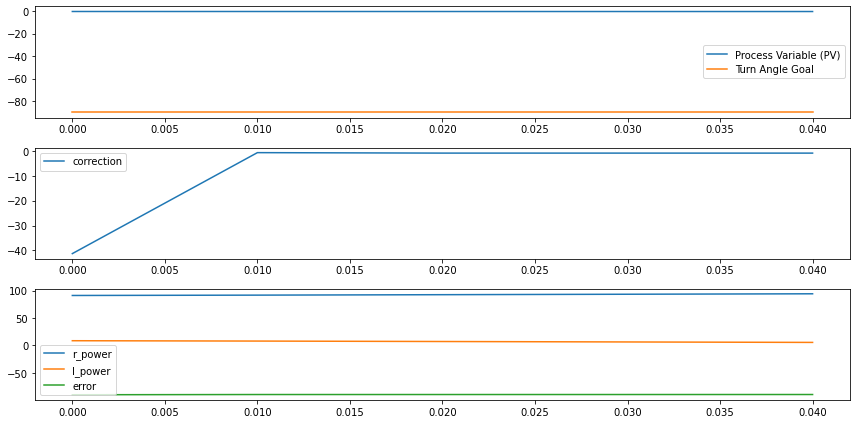

In [ ]:
dt = 0.01                  
duration = 10              
t = np.arange(0, duration, dt)

#| Behavior            | Change This | Direction |
#| ------------------- | ----------- | --------- |
#| Slow response       | Kp          | Increase  |
#| Steady-state error  | Ki          | Increase  |
#| Overshoot           | Kd          | Increase  |
#| Oscillations        | Kp or Ki    | Decrease  |
#| Sluggish with noise | Kd          | Decrease  |

Kp = 1
Ki = 0.5
Kd = 0.5
total_gain = 0.009
integral = 0
prev_error = 0
base_power = 0

y = 0  # right error
r_power = 50
l_power = 50

print("Program running")

#time.sleep(15)
original = -90
error = -90
    
l_forward = True
r_forward = True

err = []
r_val = []
l_val = []
corrections = []
time_steps = []
original_error = [];
pv = [];

curr_time = 0
prev_time = time.time();

for i in range(5):
    if frame_queue.empty():
        continue    
        
    frame_vga = frame_queue.get()
    
    b_thresholded = threshold(frame_vga)
    binary_warped = cv2.warpPerspective(b_thresholded,M, (frame_in_w, frame_in_h))[y_top:y_bottom, :]
    kernel = np.ones((20, 20), np.uint8)
    
     # Clean small blobs
    binary_cleaned = cv2.morphologyEx(binary_warped, cv2.MORPH_OPEN, kernel)

    # Fill small gaps
    binary_cleaned = cv2.morphologyEx(binary_cleaned, cv2.MORPH_CLOSE, kernel)
    
    leftx, lefty, rightx, righty = detect_lane_lines_connected_components(binary_cleaned)
    
    if leftx.size > 0 and lefty.size > 0 and rightx.size > 0 and righty.size > 0:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        angle = compute_lane_heading_angle(left_fit=left_fit, right_fit=right_fit, y_eval=y_eval)
    elif leftx.size > 0 and lefty.size > 0:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = [0,0,0]

        angle = compute_lane_heading_angle(left_fit=left_fit, y_eval=y_eval)
    elif rightx.size > 0 and righty.size > 0:
        # Fit a second order polynomial to each
        left_fit = [0,0,0]
        right_fit = np.polyfit(righty, rightx, 2)

        angle = compute_lane_heading_angle(right_fit=right_fit, y_eval=y_eval)

    print("Steering angle: " + str(angle))
    
    curr_time = time.time()
    dt = curr_time - prev_time
    
    #error = angle - y
    error = angle
    
    #Proportional
    P = Kp * error

    #Integral
    integral += error * dt
    I = Ki * integral

    #Derivative
    derivative = (error - prev_error) / dt
    D = Kd * derivative

    correction = total_gain * (P + I + D)

    y += dt * correction 
    
    #May need average power
    r_power = r_power - correction
    l_power = l_power + correction
    
    #l_power = max(0, min(100, l_power))
    #r_power = max(0, min(100, r_power))
    
    print("Correction: " + str(correction))
    print("r_power: " + str(r_power))
    print("l_power: " + str(l_power))
    print("Error: " + str(error));
    
    err.append(error) 
    r_val.append(r_power)
    l_val.append(l_power) 
    corrections.append(correction)
    original_error.append(original)
    pv.append(y)
    
    time_steps.append(i * dt)
    
    prev_error = error
    prev_time = curr_time
    
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(time_steps, pv, label='Process Variable (PV)')
plt.plot(time_steps, original_error, label='Turn Angle Goal')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(time_steps, corrections, label='correction')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(time_steps, r_val, label='r_power')
plt.plot(time_steps, l_val, label='l_power')
plt.plot(time_steps, err, label='error')
plt.legend()
plt.tight_layout()
plt.show()